# Summary and Explanations. #

Title: Improving Music Genre Classification using Song Lyrics. 

Hypothesis: Lyrics does contain important information not shown in the audio features itself that can improve audio classifiers.

Dataset: Contains Audio Features and Song Lyrics with Music genre as label and artist_and_song as unique identifyer.

Preparation: see the two notebooks below containing filtering, analysis and workflow for this project.
- data_analysis_for_prototype.ipynb
- song_text_data.ipynb

Resources: Custom built data set combining datapoints from
- Audio Features data: https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db
- Text Lyrics data: https://www.kaggle.com/datasets/edenbd/150k-lyrics-labeled-with-spotify-valence

# Imports and load custom data-set. #

In [189]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import re
import seaborn as sns

data = pd.read_csv('DATASETS/Project_dataset.csv')

# Data preparation #

In [190]:
print("Amount of datapoints with unique song+artist: ", len(data))

Amount of datapoints with unique song+artist:  12440


In [191]:
data.genre.value_counts()

genre
Country             1738
Ska                 1687
Blues               1469
Folk                1144
Dance                995
Rock                 917
Electronic           911
Reggae               864
Soul                 804
R&B                  469
Jazz                 431
Pop                  387
Hip-Hop              234
Indie                152
Children’s Music     122
Rap                  116
Name: count, dtype: int64

After careful consideration the whole point is to answer the question of this project and therefore I will remove genres below 500 datapoints. I do this because of two reasons:
- Analysis and plots will be less congested with overflowing amounts of classes.
- Removing classes with too few datapoints will balance out the dataset and make the classification easier for the models.

The downside is that the model becomes less general, and not adapted to the real world (where there are many music genres.)

In [192]:
# Create a filter for genres with value counts >= 500
valid_genres = data.genre.value_counts()
genres_to_keep = valid_genres[valid_genres >= 500].index

# Subset the DataFrame based on the filter
data = data[data.genre.isin(genres_to_keep)]

data.genre.value_counts()

genre
Country       1738
Ska           1687
Blues         1469
Folk          1144
Dance          995
Rock           917
Electronic     911
Reggae         864
Soul           804
Name: count, dtype: int64

In [193]:
print('Dummy accuracy:', round(100 * 1738 / len(data) ), '%')

Dummy accuracy: 17 %


In [194]:
# Encode the categorical data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in data.columns:
    if col in ['key', 'mode', 'time_signature', 'genre']:

        data[col] = le.fit_transform(data[col])
        data[col] = data[col].astype("category")

data.head()

,genre,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_and_song,Lyrics
0,1,0.0293,0.387,234307,0.874,0.000017,3,0.1710,-4.528,0,0.0530,168.105,2,0.674,gary allan /// get off on the pain,I don't know why I love women\r\nThat love to ...
1,1,0.1730,0.633,183600,0.444,0.000003,5,0.0821,-14.090,0,0.0264,106.111,1,0.450,"hank williams, jr. /// old habits","I kicked the habit, of smoking back some time ..."
2,1,0.0600,0.493,262720,0.780,0.000248,3,0.1920,-4.127,0,0.0485,119.996,2,0.190,carrie underwood /// chaser,I need something strong tonight\nI'm needing m...
3,1,0.7730,0.687,320040,0.543,0.000002,10,0.7050,-10.151,0,0.0521,129.296,3,0.807,bobby bare /// the winner,The hulk of a man with a beer in his hand he l...
4,1,0.0655,0.618,226187,0.790,0.006410,9,0.1100,-4.973,0,0.0445,119.987,2,0.545,brooks & dunn /// proud of the house we built,I dropped to my knees in that field on your da...


In [195]:
data.genre.value_counts()

genre
1    1738
7    1687
0    1469
4    1144
2     995
6     917
3     911
5     864
8     804
Name: count, dtype: int64

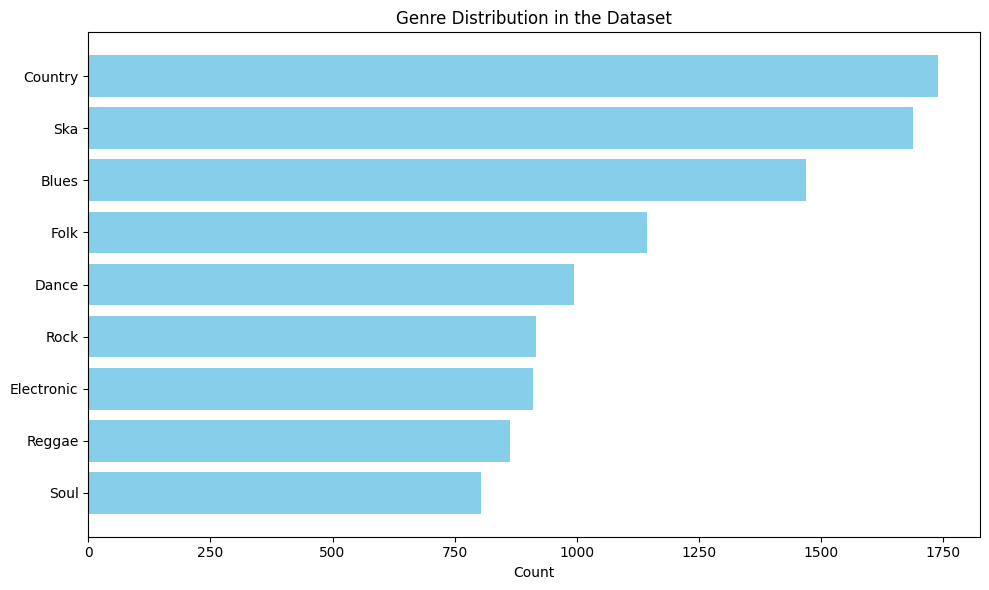

In [196]:
# from GPT
genres = ["Country", "Ska", "Blues", "Folk", "Dance", "Rock", "Electronic", "Reggae", "Soul"]
counts = [1738, 1687, 1469, 1144, 995, 917, 911, 864, 804]

plt.figure(figsize=(10,6))
plt.barh(genres, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Genre Distribution in the Dataset')
plt.gca().invert_yaxis()  # Invert y-axis to have the genre with the highest count at the top
plt.tight_layout()
plt.savefig('genre_distribution.png')
plt.show()

In [197]:
data.genre

0        1
1        1
2        1
3        1
4        1
        ..
12435    8
12436    8
12437    8
12438    8
12439    8
Name: genre, Length: 10529, dtype: category
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]

### Prepare the datasets for audio feature and text classification

In [198]:
labels = data.genre
audio_data = data.drop(columns=['genre', 'artist_and_song','Lyrics'])

# Audio classification train test data.
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(audio_data, labels, test_size=0.2,random_state=42)

# print(X_test_audio)
# Create train test data for text classification.
idx_train = X_train_audio.index
idx_test = X_test_audio.index

X_train_text = data.loc[idx_train].Lyrics.tolist()
X_test_text = data.loc[idx_test].Lyrics.tolist()
y_train_text = y_train_audio.tolist()
y_test_text = y_test_audio.tolist()



In [199]:
# Scale the data for Audio classification.
scaler = StandardScaler()
X_train_audio = scaler.fit_transform(X_train_audio)
X_test_audio = scaler.transform(X_test_audio)

# Audio Feature Classifications (MLP, Naive Bayes, XGBoost, TabNet)

In [200]:
# Initialize the model
MLP_clf = MLPClassifier()#hidden_layer_sizes=(256,128,64), max_iter=200)

# Train the model
MLP_clf.fit(X_train_audio, y_train_audio)
MLP_y_pred = MLP_clf.predict(X_test_audio)
MLP_y_proba_pred = MLP_clf.predict_proba(X_test_audio)

# Calculate the classification report for this fold
MLP_report = classification_report(y_test_audio, MLP_y_pred)
print(MLP_report)


              precision    recall  f1-score   support

           0       0.45      0.39      0.42       332
           1       0.51      0.69      0.59       366
           2       0.39      0.35      0.37       195
           3       0.52      0.57      0.54       163
           4       0.38      0.39      0.39       225
           5       0.49      0.55      0.52       162
           6       0.28      0.14      0.18       175
           7       0.71      0.78      0.74       333
           8       0.31      0.21      0.25       155

    accuracy                           0.49      2106
   macro avg       0.45      0.45      0.44      2106
weighted avg       0.47      0.49      0.48      2106



/Users/hanbiru/Documents/code/text_mining_project-TDDE16/text_mining_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [201]:
naive_clf = GaussianNB()
naive_clf.fit(X_train_audio, y_train_audio)

naive_y_pred = naive_clf.predict(X_test_audio)

# Calculate the classification report for this fold
naive_report = classification_report(y_test_audio, naive_y_pred)
print(naive_report)

              precision    recall  f1-score   support

           0       0.48      0.07      0.13       332
           1       0.37      0.73      0.50       366
           2       0.32      0.34      0.33       195
           3       0.48      0.40      0.43       163
           4       0.37      0.39      0.38       225
           5       0.38      0.49      0.43       162
           6       0.30      0.15      0.20       175
           7       0.59      0.69      0.64       333
           8       0.24      0.12      0.16       155

    accuracy                           0.41      2106
   macro avg       0.39      0.38      0.35      2106
weighted avg       0.41      0.41      0.37      2106



In [202]:
# !pip install pytorch-tabnet

In [203]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_clf = TabNetClassifier()
tabnet_clf.fit(X_train_audio, y_train_audio, max_epochs=300)

/Users/hanbiru/Documents/code/text_mining_project-TDDE16/text_mining_env/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/hanbiru/Documents/code/text_mining_project-TDDE16/text_mining_env/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.42333 |  0:00:00s
epoch 1  | loss: 2.16093 |  0:00:01s
epoch 2  | loss: 2.07465 |  0:00:01s
epoch 3  | loss: 1.98887 |  0:00:02s
epoch 4  | loss: 1.92539 |  0:00:02s
epoch 5  | loss: 1.88398 |  0:00:03s
epoch 6  | loss: 1.83184 |  0:00:03s
epoch 7  | loss: 1.80264 |  0:00:04s
epoch 8  | loss: 1.75747 |  0:00:04s
epoch 9  | loss: 1.7224  |  0:00:05s
epoch 10 | loss: 1.69629 |  0:00:05s
epoch 11 | loss: 1.68336 |  0:00:06s
epoch 12 | loss: 1.65379 |  0:00:06s
epoch 13 | loss: 1.64482 |  0:00:07s
epoch 14 | loss: 1.63065 |  0:00:07s
epoch 15 | loss: 1.61996 |  0:00:07s
epoch 16 | loss: 1.61731 |  0:00:08s
epoch 17 | loss: 1.59735 |  0:00:08s
epoch 18 | loss: 1.58406 |  0:00:09s
epoch 19 | loss: 1.57249 |  0:00:09s
epoch 20 | loss: 1.57125 |  0:00:10s
epoch 21 | loss: 1.55725 |  0:00:10s
epoch 22 | loss: 1.54043 |  0:00:11s
epoch 23 | loss: 1.54259 |  0:00:11s
epoch 24 | loss: 1.54279 |  0:00:12s
epoch 25 | loss: 1.53082 |  0:00:12s
epoch 26 | loss: 1.52969 |  0:00:13s
e

In [204]:
tabnet_y_pred = tabnet_clf.predict(X_test_audio)
tabnet_y_pred_proba = tabnet_clf.predict_proba(X_test_audio)
tabnet_report = classification_report(y_test_audio, tabnet_y_pred)
print(tabnet_report)

              precision    recall  f1-score   support

           0       0.40      0.43      0.41       332
           1       0.49      0.69      0.58       366
           2       0.42      0.29      0.34       195
           3       0.50      0.51      0.50       163
           4       0.36      0.40      0.38       225
           5       0.43      0.49      0.46       162
           6       0.32      0.13      0.18       175
           7       0.71      0.74      0.72       333
           8       0.24      0.13      0.17       155

    accuracy                           0.47      2106
   macro avg       0.43      0.42      0.41      2106
weighted avg       0.45      0.47      0.45      2106



In [205]:
# !pip install xgboost

In [206]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_audio, y_train_audio)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [207]:
xgb_y_pred = xgb_clf.predict(X_test_audio)
xgb_y_pred_proba = xgb_clf.predict_proba(X_test_audio)
xgb_report = classification_report(y_test_audio, xgb_y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       332
           1       0.51      0.63      0.56       366
           2       0.43      0.39      0.41       195
           3       0.53      0.55      0.54       163
           4       0.37      0.41      0.39       225
           5       0.48      0.50      0.49       162
           6       0.28      0.20      0.23       175
           7       0.73      0.76      0.75       333
           8       0.30      0.23      0.26       155

    accuracy                           0.49      2106
   macro avg       0.45      0.45      0.45      2106
weighted avg       0.48      0.49      0.48      2106



In [208]:
best_XGB_params = {
                'max_depth': 4,
                'learning_rate': 0.03711299495104505,
                'n_estimators': 447,
                'min_child_weight': 10,
                'gamma': 0.002238238469617126,
                'subsample': 0.849826493051354,
                'colsample_bytree': 0.9977007889943236,
                'reg_alpha': 0.15538382519234734,
                'reg_lambda': 7.07955517130104e-07,
                'enable_categorical' : True,
                'tree_method' : "hist"
               }

xgb2_clf = xgb.XGBClassifier(**best_XGB_params)

xgb2_clf.fit(X_train_audio, y_train_audio)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9977007889943236, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.002238238469617126, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03711299495104505, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=447, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [209]:
xgb2_y_pred = xgb2_clf.predict(X_test_audio)
xgb2_report = classification_report(y_test_audio, xgb2_y_pred)
print(xgb2_report)

              precision    recall  f1-score   support

           0       0.46      0.43      0.44       332
           1       0.50      0.66      0.57       366
           2       0.43      0.38      0.40       195
           3       0.58      0.64      0.61       163
           4       0.39      0.39      0.39       225
           5       0.51      0.56      0.53       162
           6       0.29      0.16      0.21       175
           7       0.74      0.78      0.76       333
           8       0.34      0.25      0.28       155

    accuracy                           0.51      2106
   macro avg       0.47      0.47      0.47      2106
weighted avg       0.49      0.51      0.50      2106



In [210]:
#!pip install imbalanced-learn==0.7.0

In [211]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train_audio, y_train_audio)

print("Inspect oversampling: \n",y_res.value_counts())

xgb3_clf = xgb.XGBClassifier()#**best_XGB_params)

xgb3_clf.fit(X_res, y_res)

Inspect oversampling: 
 genre
0    1372
1    1372
2    1372
3    1372
4    1372
5    1372
6    1372
7    1372
8    1372
Name: count, dtype: int64


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [212]:
xgb3_y_pred = xgb3_clf.predict(X_test_audio)
xgb3_report = classification_report(y_test_audio, xgb3_y_pred)
print(xgb3_report)

              precision    recall  f1-score   support

           0       0.45      0.38      0.41       332
           1       0.52      0.54      0.53       366
           2       0.37      0.39      0.38       195
           3       0.53      0.60      0.56       163
           4       0.36      0.38      0.37       225
           5       0.49      0.51      0.50       162
           6       0.23      0.20      0.21       175
           7       0.75      0.73      0.74       333
           8       0.28      0.30      0.29       155

    accuracy                           0.47      2106
   macro avg       0.44      0.45      0.44      2106
weighted avg       0.47      0.47      0.47      2106



In [213]:
MLP_os_clf = MLPClassifier()
# Train the model
MLP_os_clf.fit(X_res, y_res)
MLP_os_y_pred = MLP_clf.predict(X_test_audio)
MLP_os_y_proba_pred = MLP_clf.predict_proba(X_test_audio)

# Calculate the classification report for this fold
MLP_os_report = classification_report(y_test_audio, MLP_y_pred)
print(MLP_report)

              precision    recall  f1-score   support

           0       0.45      0.39      0.42       332
           1       0.51      0.69      0.59       366
           2       0.39      0.35      0.37       195
           3       0.52      0.57      0.54       163
           4       0.38      0.39      0.39       225
           5       0.49      0.55      0.52       162
           6       0.28      0.14      0.18       175
           7       0.71      0.78      0.74       333
           8       0.31      0.21      0.25       155

    accuracy                           0.49      2106
   macro avg       0.45      0.45      0.44      2106
weighted avg       0.47      0.49      0.48      2106



/Users/hanbiru/Documents/code/text_mining_project-TDDE16/text_mining_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [214]:
# tabnet2_clf = TabNetClassifier()
# tabnet2_clf.fit(X_res, y_res)

In [215]:
# tabnet2_y_pred = tabnet2_clf.predict(X_test_audio)
# tabnet2_report = classification_report(y_test_audio, tabnet2_y_pred)
# print(tabnet2_report)


# Text Classification (Finetuning BERT)

In [216]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [217]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

In [218]:
# #Some testing 
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# text = X_train_text[120]
# print(text)
# test = tokenizer(text)
# test

In [219]:
def processing_for_bert(batch, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
    
    N = len(batch)
    texts, final_labels = [0]*N, [0]*N
    
    for i in range(N):
        
        texts[i] = batch[i][0]
        final_labels[i] = batch[i][1] 

    #pad to longest length of longest sentence in batch!
    tokenized = tokenizer(texts, padding=True, max_length=512, truncation=True)
    #print(tokenized)
    token_id = torch.tensor(tokenized['input_ids'])
    attention_masks = torch.tensor(tokenized['attention_mask'])
    return token_id.to(device), attention_masks.to(device), torch.tensor(final_labels).to(device) 

# token_id, attention_masks, labels = processing_for_bert(X_train_text[:2], y_train_text[:2])  

In [220]:
# Function to calculate the accuracy of our predictions
def accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #print(pred_flat)
    #print(labels_flat)
    return np.sum(preds_flat == labels_flat)/len(preds_flat)

In [221]:
def create_label_map(num_categories):

    #mapping for labels
    zero_vec = [0] * num_categories 
    label_map = {}
    for i in range(num_categories-1):
        gold_vec = zero_vec.copy()
        gold_vec[i] = 1
        label_map[i] = gold_vec
    # print(label_map)
    return label_map

def create_text_data(X,Y):
    """Create data of shape [(x1,y1), (x2,y2),...,]"""
    data = []
    for i in range(len(X)):
        data.append((X[i],Y[i]))
    return data

In [222]:
def train_model(train_data, n_epochs=7, batch_size=16, lr=1e-5):
    # mapping for labels
    num_categories = 9  # Nine music genres
    # label_map = create_label_map(num_categories)

    # Prepare the data loaders
    train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=processing_for_bert)

    # Build the classifier
    classifier = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_categories).to(device)

    # Initialise the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

    # Training loop
    try:
        for epoch in range(n_epochs):
            train_losses = 0
            classifier.train()
            for batch in tqdm(train_loader):
                train_token_id = batch[0]
                train_attention_masks = batch[1]
                train_labels = batch[2]

                # Reset the accumulated gradients
                optimizer.zero_grad()

                # Forward pass
                output = classifier(train_token_id,
                                    token_type_ids=None,
                                    attention_mask=train_attention_masks,
                                    labels=train_labels)

                # Save loss
                train_losses += output.loss.item()

                # Backward pass; propagates the loss and computes the gradients
                output.loss.backward()
                # Update the parameters of the model
                optimizer.step()

            print('epoch_avg_train_loss:', round(train_losses / len(train_loader), 3))

        # Save model parameters
        torch.save(classifier.state_dict(), 'trained_model.pth')

    except KeyboardInterrupt:
        pass

    return classifier


In [223]:
def test_model(classifier, test_data, batch_size=16):
    
    test_loader = DataLoader(test_data, batch_size, collate_fn=processing_for_bert)

    classifier.eval()

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            val_token_id = batch[0]
            val_attention_masks = batch[1]
            val_labels = batch[2]

            output = classifier(val_token_id,
                                token_type_ids=None,
                                attention_mask=val_attention_masks,
                                labels=val_labels)

            # Convert logits to probabilities using softmax
            probs = F.softmax(output.logits, dim=1)
            all_probs.append(probs)

            # Store predictions and true labels for computing the weighted F1 later
            preds_flat = np.argmax(output.logits.detach().cpu().numpy(), axis=1)
            all_preds.extend(preds_flat.tolist())
            all_labels.extend(val_labels.to('cpu').numpy().tolist())

    report = classification_report(all_labels, all_preds)
        
    all_probs_tensor = torch.cat(all_probs, dim=0)
    return report, all_probs_tensor, all_preds


In [224]:
text_train_data = create_text_data(X_train_text, y_train_text)
text_test_data = create_text_data(X_test_text, y_test_text)

In [225]:
# model = train_model(text_train_data)

In [226]:
# Load model trained from Kaggle GPU
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9).to(device)

# Load the state dictionary from the file
state_dict = torch.load("Kaggle_runs/7_epochs/7_epochs.pth", map_location=device)

# Remove the unexpected key
if "bert.embeddings.position_ids" in state_dict:
    del state_dict["bert.embeddings.position_ids"]

# Load the model with the modified state dictionary
model.load_state_dict(state_dict)


model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [227]:
text_pred_report, text_pred_probs, text_preds = test_model(model, text_test_data)

100%|██████████| 132/132 [08:39<00:00,  3.94s/it]


In [228]:
print(text_pred_report)

              precision    recall  f1-score   support

           0       0.54      0.40      0.46       332
           1       0.77      0.66      0.71       366
           2       0.43      0.51      0.47       195
           3       0.52      0.49      0.50       163
           4       0.41      0.31      0.35       225
           5       0.88      0.46      0.61       162
           6       0.23      0.43      0.30       175
           7       0.57      0.71      0.63       333
           8       0.42      0.43      0.42       155

    accuracy                           0.51      2106
   macro avg       0.53      0.49      0.49      2106
weighted avg       0.55      0.51      0.52      2106



In [229]:
# print(text_preds)

In [230]:
# Save the array
if isinstance(text_pred_probs, torch.Tensor):
    text_pred_probs = text_pred_probs.cpu().numpy()
np.save('text_pred_probs.npy', text_pred_probs)

# Plotting and Analysis

In [231]:
def plot_f1_scores(cr, class_names):
    # Split the report into lines
    lines = cr.split('\n')
    
    f1_scores = []

    # For each line, extract the F1-score
    for line in lines[2:-5]:  # Skipping initial and last few lines with average scores
        t = re.split(r'\s+', line.strip())
        f1_scores.append(float(t[3]))
    
    # Plotting
    plt.bar(class_names, f1_scores, color='g', edgecolor='grey')
    plt.xlabel('Classes', fontweight='bold', fontsize=15)
    plt.ylabel('F1-Score', fontweight='bold', fontsize=15)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    


def plot_correlation(v1, v2, class_names=None):
    """
    Plots the correlation between two vectors v1 and v2 using a confusion matrix.
    """
    if len(v1) != len(v2):
        raise ValueError("Both vectors should have the same length")

    # Determine the unique classes from the vectors
    if class_names:
        classes = np.arange(len(class_names))
    else:
        classes = np.unique(np.concatenate([v1, v2]))

    # Create a confusion matrix
    confusion_matrix = np.zeros((len(classes), len(classes)))

    for i, j in zip(v1, v2):
        confusion_matrix[i, j] += 1

    # Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names or classes, yticklabels=class_names or classes)
    plt.xlabel(f"Predictions from v2")
    plt.ylabel(f"Predictions from v1")
    plt.title("Correlation between Two Classification Predictions")
    plt.show()


### Text vs Audio Feature Predictions

In [232]:
# Music genres mapped with correct category num
class_names = ["Blues", "Country", "Dance", "Electronic", "Folk", "Reggae", "Rock", "Ska", "Soul"]

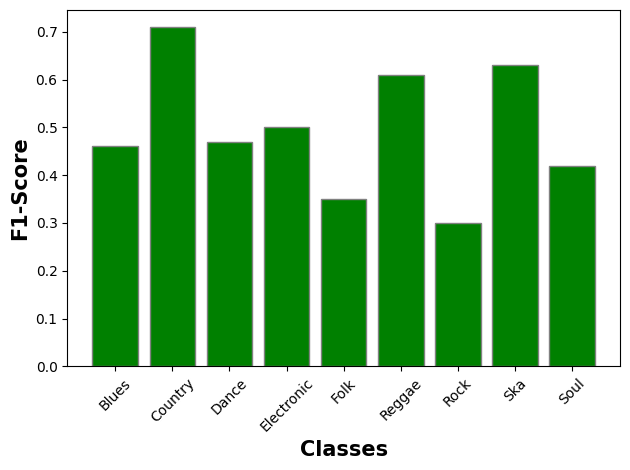

In [233]:
plot_f1_scores(text_pred_report, class_names)

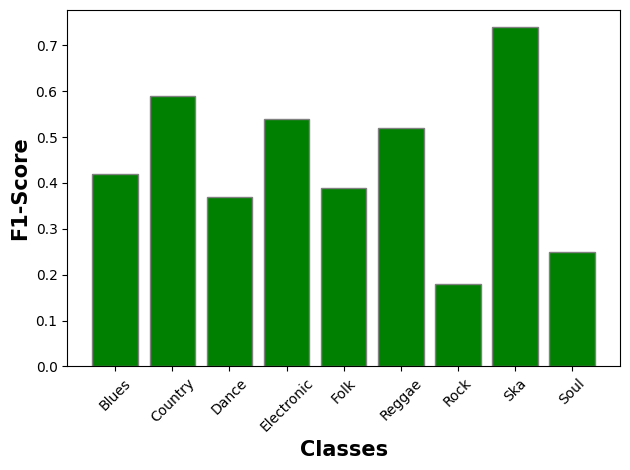

In [234]:
plot_f1_scores(MLP_report, class_names)

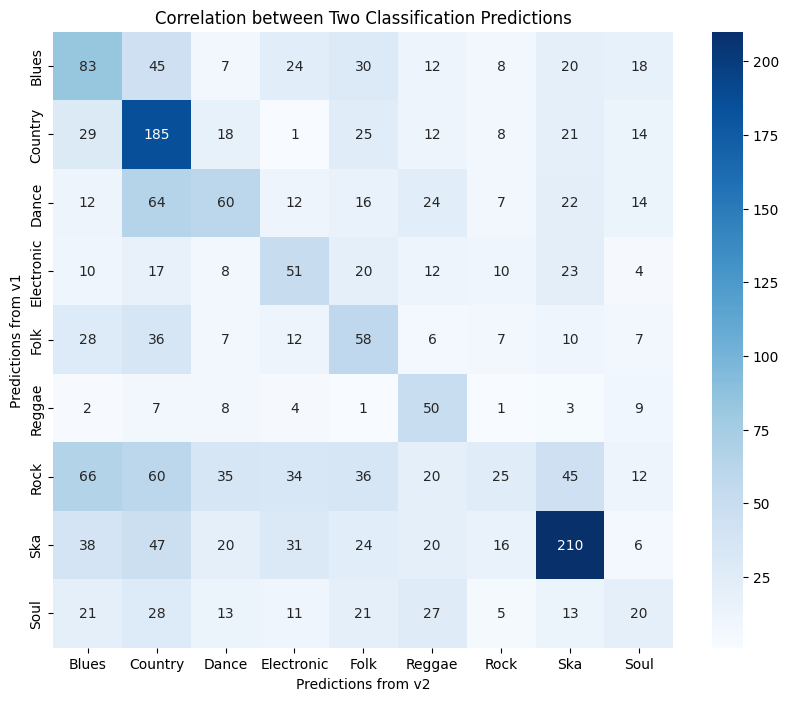

In [235]:
plot_correlation(text_preds, MLP_y_pred, class_names)

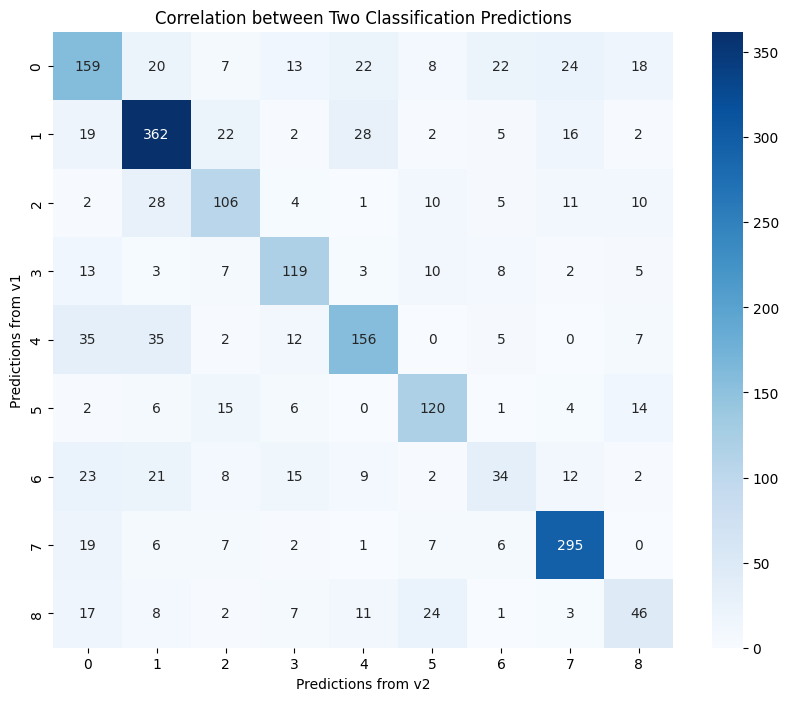

In [236]:
plot_correlation(xgb_y_pred, MLP_y_pred)

In [237]:
from sklearn.metrics import cohen_kappa_score
kappa1 = cohen_kappa_score(text_preds, MLP_y_pred)
kappa2 = cohen_kappa_score(text_preds, xgb_y_pred)
kappa3 = cohen_kappa_score(text_preds, naive_y_pred)
kappa4 = cohen_kappa_score(text_preds, tabnet_y_pred)

kappa5 = cohen_kappa_score(xgb_y_pred, MLP_y_pred)
kappa6 = cohen_kappa_score(xgb_y_pred, naive_y_pred)
kappa7 = cohen_kappa_score(xgb_y_pred, tabnet_y_pred)

print("text_preds, MLP_y_pred: ",kappa1)
print("text_preds, xgb_y_pred: ",kappa2)
print("text_preds, naive_y_pred: ",kappa3)
print("text_preds, tabnet_y_pred: ",kappa4)


print("xgb_y_pred, MLP_y_pred: ",kappa5)
print("xgb_y_pred, naive_y_pred: ",kappa6)
print("xgb_y_pred, tabnet_y_pred: ",kappa7)

text_preds, MLP_y_pred:  0.2616363100322249
text_preds, xgb_y_pred:  0.269093204292026
text_preds, naive_y_pred:  0.20408019341317463
text_preds, tabnet_y_pred:  0.24563668782188597
xgb_y_pred, MLP_y_pred:  0.6098033015650683
xgb_y_pred, naive_y_pred:  0.4575706583330471
xgb_y_pred, tabnet_y_pred:  0.5745063825879329


In [238]:
# # Load the numpy array
# loaded_probs_array = np.load('/kaggle/working/text_pred_probs.npy')
# print(loaded_probs_array)
# # Convert the numpy array back to a tensor if needed
# loaded_probs_tensor = torch.tensor(loaded_probs_array)

# Combining the models

In [239]:
def average_and_predict(pred1, pred2):
    """
    Given two prediction vectors, this function averages their probabilities and outputs the prediction of each datapoint.
    
    Args:
    - pred1: List of lists. Outer list is the number of datapoints and inner list is the probability for each class.
    - pred2: List of lists. Outer list is the number of datapoints and inner list is the probability for each class.

    Returns:
    - List of predicted classes for each datapoint.
    """
    
    # Checking if both prediction vectors have the same shape
    assert len(pred1) == len(pred2), "Both prediction vectors should have the same number of datapoints"
    for i in range(len(pred1)):
        assert len(pred1[i]) == len(pred2[i]), f"Datapoint {i} has different number of classes in the two prediction vectors"
    
    averaged_predictions = [(p1_i + p2_i) / 2 for p1, p2 in zip(pred1, pred2) for p1_i, p2_i in zip(p1, p2)]
    
    # Reshape the averaged_predictions to have the same shape as pred1 or pred2
    reshaped_averaged_predictions = [averaged_predictions[i:i+len(pred1[0])] for i in range(0, len(averaged_predictions), len(pred1[0]))]
    
    # Find the index (i.e., class) with the maximum probability for each datapoint
    predictions = [max(enumerate(p), key=lambda x: x[1])[0] for p in reshaped_averaged_predictions]
    
    return predictions

def weighted_average_and_predict(pred1, pred2):
    """
    Combines two prediction vectors using a weighted average based on their certainties.
    
    Args:
    - pred1: List of lists. Outer list is the number of datapoints and inner list is the probability for each class.
    - pred2: List of lists. Outer list is the number of datapoints and inner list is the probability for each class.

    Returns:
    - List of predicted classes for each datapoint.
    """
    
    # Checking if both prediction vectors have the same shape
    assert len(pred1) == len(pred2), "Both prediction vectors should have the same number of datapoints"
    for i in range(len(pred1)):
        assert len(pred1[i]) == len(pred2[i]), f"Datapoint {i} has different number of classes in the two prediction vectors"
    
    # Calculate certainty for each prediction vector
    certainties_pred1 = [max(p) for p in pred1]
    certainties_pred2 = [max(p) for p in pred2]
    
    # Normalize the certainties for weighting
    normalized_weights_pred1 = [c1 / (c1 + c2) for c1, c2 in zip(certainties_pred1, certainties_pred2)]
    normalized_weights_pred2 = [c2 / (c1 + c2) for c1, c2 in zip(certainties_pred1, certainties_pred2)]
    
    # Compute weighted average
    combined_probs = [[p1_i * w1 + p2_i * w2 for p1_i, p2_i in zip(p1, p2)] for p1, p2, w1, w2 in zip(pred1, pred2, normalized_weights_pred1, normalized_weights_pred2)]
    
    # Predict based on the combined probabilities
    predictions = [max(enumerate(p), key=lambda x: x[1])[0] for p in combined_probs]
    
    return predictions


In [240]:
# text_pred_probs = np.load("Kaggle_runs/7_epochs/7_epochs.npy")

In [241]:
combined_avg_pred = average_and_predict(MLP_y_proba_pred, text_pred_probs)
combined_weighted_avg_pred = weighted_average_and_predict(MLP_y_proba_pred, text_pred_probs)

combined_avg_pred_report = classification_report(y_test_audio, combined_avg_pred)
print(combined_avg_pred_report)

combined_weighted_avg_pred_report = classification_report(y_test_audio, combined_weighted_avg_pred)
print(combined_weighted_avg_pred_report)

              precision    recall  f1-score   support

           0       0.58      0.42      0.49       332
           1       0.75      0.72      0.73       366
           2       0.47      0.52      0.50       195
           3       0.61      0.64      0.62       163
           4       0.43      0.36      0.39       225
           5       0.83      0.53      0.65       162
           6       0.26      0.39      0.31       175
           7       0.64      0.83      0.72       333
           8       0.45      0.40      0.42       155

    accuracy                           0.56      2106
   macro avg       0.56      0.53      0.54      2106
weighted avg       0.58      0.56      0.56      2106

              precision    recall  f1-score   support

           0       0.57      0.42      0.48       332
           1       0.75      0.72      0.73       366
           2       0.46      0.51      0.49       195
           3       0.60      0.63      0.61       163
           4       0.43 

In [242]:
combined_avg_pred = average_and_predict(xgb_y_pred_proba, text_pred_probs)
combined_weighted_avg_pred = weighted_average_and_predict(xgb_y_pred_proba, text_pred_probs)

combined_avg_pred_report = classification_report(y_test_audio, combined_avg_pred)
print(combined_avg_pred_report)

combined_weighted_avg_pred_report = classification_report(y_test_audio, combined_weighted_avg_pred)
print(combined_weighted_avg_pred_report)

              precision    recall  f1-score   support

           0       0.56      0.45      0.50       332
           1       0.74      0.74      0.74       366
           2       0.45      0.49      0.47       195
           3       0.60      0.58      0.59       163
           4       0.45      0.38      0.41       225
           5       0.81      0.56      0.66       162
           6       0.27      0.37      0.31       175
           7       0.64      0.83      0.72       333
           8       0.45      0.39      0.42       155

    accuracy                           0.56      2106
   macro avg       0.55      0.53      0.54      2106
weighted avg       0.57      0.56      0.56      2106

              precision    recall  f1-score   support

           0       0.57      0.44      0.50       332
           1       0.74      0.73      0.74       366
           2       0.46      0.50      0.48       195
           3       0.59      0.58      0.59       163
           4       0.45 

In [243]:
combined_avg_pred = average_and_predict(tabnet_y_pred_proba, text_pred_probs)
combined_weighted_avg_pred = weighted_average_and_predict(tabnet_y_pred_proba, text_pred_probs)

combined_avg_pred_report = classification_report(y_test_audio, combined_avg_pred)
print(combined_avg_pred_report)

combined_weighted_avg_pred_report = classification_report(y_test_audio, combined_weighted_avg_pred)
print(combined_weighted_avg_pred_report)


              precision    recall  f1-score   support

           0       0.55      0.42      0.48       332
           1       0.75      0.72      0.73       366
           2       0.46      0.49      0.48       195
           3       0.59      0.59      0.59       163
           4       0.40      0.35      0.37       225
           5       0.82      0.52      0.63       162
           6       0.27      0.39      0.32       175
           7       0.63      0.82      0.71       333
           8       0.44      0.39      0.41       155

    accuracy                           0.55      2106
   macro avg       0.54      0.52      0.52      2106
weighted avg       0.56      0.55      0.55      2106

              precision    recall  f1-score   support

           0       0.56      0.42      0.48       332
           1       0.74      0.72      0.73       366
           2       0.45      0.48      0.46       195
           3       0.60      0.60      0.60       163
           4       0.39 